In [10]:
import numpy as np
import pandas as pd
import os, cv2
import aniposelib
import scipy.io

In [2]:
data_path = '/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole_stage57_2022-11-04/DLTdv8_data_V1xypts.csv'
calib_path = '/mnt/soma_cifs/Iyer/Filming/02112022b/calibrationwater_2030/calibration.toml'
label3d_path = '/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/label3d_data.mat';
label3d_path1 = '/mnt/soma_cifs/Iyer/DANNCE_Files/backup/tadpole-stage57_Nov2022a/label3d_data.mat';

n_frames = 46
n_pts = 23
tail_framenames = np.sort(os.listdir('/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/'))[:5]

In [337]:
def add_pts(data_path, calib_path, label3d_path, n_frames, n_pts):
    df = pd.read_csv(data_path)
    pts = np.array([get_columns(df, 'cam1'), get_columns(df, 'cam2'), get_columns(df, 'cam3')])
    calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
    xyz = calibration_.triangulate_ransac(pts)[0]
    xyz = xyz.reshape(n_frames, 13, 3)
    matfile_ = scipy.io.loadmat(label3d_path1)['label3d_data'];

    J = []
    for i in tail_framenames:
        I = sorted([j for j in os.listdir(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{i}') if 'png' in j])
        for j in I:
            J.append(f'/home/iyer_la/Documents/TailAnnotated/DANNCE/points_{i}_{j[3:7]}.npy')
    z = np.zeros((len(J), 10, 3)) * np.nan
    for i, j in enumerate(J):
        try:
            z[i] = np.load(j)
        except:
            print(j)

    z = z.reshape(-1, 30)
    df_np = np.concatenate((df_np, z), axis = 1)
    df_np = df_np.reshape(-1, 3)
    df_cam = calibration_.project(df_np)
    df_cam = np.rint(df_cam).astype('int32')

    for cam_num in [0,1,2]:
        matfile_['labelData'][0][0][cam_num][0]['data_2d'][0][0] = df_cam[cam_num].reshape(n_frames, n_pts*2)
        matfile_['labelData'][0][0][cam_num][0]['data_3d'][0][0] = df.to_numpy()
        matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0]) - 1
        matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0]) - 1

    scipy.io.savemat(label3d_path, {'camnames':matfile_['camnames'][0][0], 'params':matfile_['params'][0][0], 'sync':matfile_['sync'][0][0], 'labelData':matfile_['labelData'][0][0]})

In [338]:
add_pts(data_path, calib_path, label3d_path, n_frames, n_pts)
matfile_ = scipy.io.loadmat(label3d_path)

In [357]:
J = []
for i in tail_framenames:
    I = sorted([j for j in os.listdir(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{i}') if 'png' in j])
    for j in I:
        J.append(f'/home/iyer_la/Documents/TailAnnotated/DANNCE/points_{i}_{j[3:7]}.npy')

In [361]:
for i, j in enumerate(J):
    print(i, j)

0 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0027.npy
1 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0127.npy
2 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0249.npy
3 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0404.npy
4 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0513.npy
5 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0583.npy
6 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0777.npy
7 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0842.npy
8 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0987.npy
9 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_33_5226-7495_0039.npy
10 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_33_5226-7495_0201.npy
11 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_33_5226-7495_0452.npy
12 /home/iyer_la/Documents/TailAnnotated/DANNCE/points_33_5226-7495_

In [435]:
J = []
for i in tail_framenames:
    I = sorted([j for j in os.listdir(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{i}') if 'png' in j])
    for j in I:
        J.append(f'/home/iyer_la/Documents/TailAnnotated/DANNCE/points_{i}_{j[3:7]}.npy')
z = np.zeros((len(J), 10, 3)) * np.nan
for i, j in enumerate(J):
    try:
        z[i] = np.load(j)
    except:
        print(j)

/home/iyer_la/Documents/TailAnnotated/DANNCE/points_22_10635-11787_0027.npy


In [437]:
z.shape

(88, 10, 3)

In [277]:
load_label3d_data(path='/home/iyer_la/Downloads/label3d_dannce.mat', key='labelData')[0]['data_sampleID']

array([[   271,    721,   1681,   2301,   2341,   5761,   6961,   8641,
          9571,   9661,   9841,  10741,  11881,  12251,  12791,  13501,
         14341,  14471,  14811,  17951,  19401,  20031,  20081,  22491,
         23621,  24981,  25751,  26711,  30541,  31181,  32391,  34791,
         35161,  35831,  39011,  42701,  47511,  49331,  50881,  51651,
         68451,  70641,  72161,  72741,  74771,  76081,  78331,  81811,
         82581,  82821,  84091,  87201,  89221,  90151,  90861,  93251,
         93951,  94011,  96281,  96601,  97091,  99041, 101681, 107011,
        107681, 110201, 127671, 127741, 136071, 137381, 142561, 146701,
        152521, 155021, 157521, 163461, 166161, 167251, 169871, 178341,
        178581]], dtype=int32)

In [283]:
load_label3d_data(path=label3d_path, key='labelData')[0]['data_sampleID']

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]],
      dtype=uint16)

In [12]:
from typing import List, Dict, Text, Union
def load_label3d_data(path: Text, key: Text):
    """Load Label3D data
    Args:
        path (Text): Path to Label3D file
        key (Text): Field to access
    Returns:
        TYPE: Data from field
    """
    d = scipy.io.loadmat(path)[key]
    dataset = [f[0] for f in d]

    # Data are loaded in this annoying structure where the array
    # we want is at dataset[i][key][0,0], as a nested array of arrays.
    # Simplify this structure (a numpy record array) here.
    # Additionally, cannot use views here because of shape mismatches. Define
    # new dict and return.
    data = []
    for d in dataset:
        d_ = {}
        for key in d.dtype.names:
            d_[key] = d[key][0, 0]
        data.append(d_)
    return data

In [133]:
load_camnames(label3d_path)

['Camera1', 'Camera2', 'Camera3']

In [122]:
def load_camnames(path: Text) -> Union[List, None]:
    """Load camera names from .mat file.
    Args:
        path (Text): Path to .mat file with "camnames" field
    Returns:
        Union[List, None]: List of cameranames
    """
    label_3d_file = scipy.io.loadmat(path)
    if "camnames" in label_3d_file:
        names = label_3d_file["camnames"][:]
        if len(names) != len(label_3d_file["labelData"]):
            camnames = [name[0] for name in names[0]]
        else:
            camnames = [name[0][0] for name in names]
    else:
        camnames = None
    return camnames

In [243]:
matfile_['labelData'][2][0][0][0]['data_frame']

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
        48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80, 81, 82, 83, 84, 85, 86, 87]], dtype=uint16)

In [253]:
v = cv2.VideoCapture('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/videos/Camera1/0.avi')
total = int(v.get(cv2.CAP_PROP_FRAME_COUNT))

In [14]:
def get_frame(idx: int, grayscale: bool = None) -> np.ndarray:
    """See :class:`Video`."""

    v.set(cv2.CAP_PROP_POS_FRAMES, idx)
    success, frame = v.read()

    if not success or frame is None:
        raise KeyError(f"Unable to load frame {idx}")


    return frame

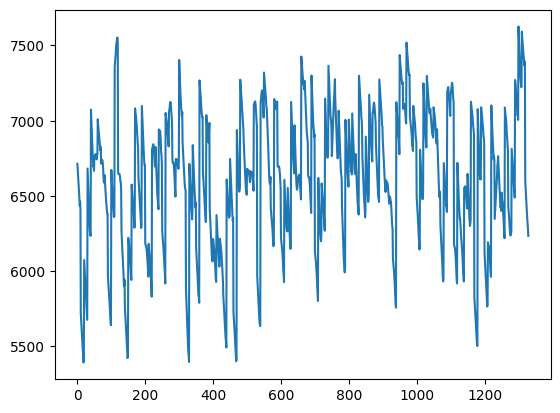

In [15]:
path_ = '/home/iyer_la/Documents/TailAnnotated/DANNCE/'
files_ = [path_ + i for i in os.listdir(path_) if 'points' in i]
z = []
for fi in files_:
    n = np.load(fi)
    z.append(np.linalg.norm(np.diff(n), axis = 1))
z = np.array(z).reshape(-1)
plt.plot(z)
plt.hist(z)

In [261]:
matfile_ = scipy.io.loadmat('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/label3d_dannce.mat')

In [473]:
v = cv2.VideoCapture('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/videos/Camera2/0.avi')
df = load_label3d_data('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/label3d_data.mat', 'labelData')[1]['data_2d']

In [21]:
for cam_num in [1,2,3]:
    v = cv2.VideoCapture(f'/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/videos/Camera{cam_num}/0.avi')
    df = load_label3d_data('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/label3d_data.mat', 'labelData')[cam_num - 1]['data_2d']
    for idx in range(46):
        x = df[idx][::2].astype(np.int32)
        y = df[idx][1::2].astype(np.int32)
        im_ = get_frame(idx)
        for i in range(len(x)):
            im_ = cv2.circle(im_, [x[i], y[i]], radius=4, color=(0, 255, 255), thickness=-1)
        cv2.imwrite(f'/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022b/test/c{cam_num}_{idx}.png', im_)

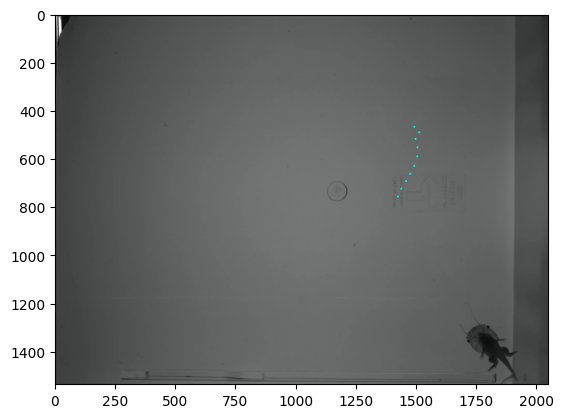

In [329]:
v = cv2.VideoCapture('/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole-stage57_Nov2022a/videos/Camera1/0.avi')
idx = 1
im_ = get_frame(idx)
x = calibration_.project(np.load('/home/iyer_la/Documents/TailAnnotated/DANNCE/points_1_0-1477_0151.npy'))[2]
for i in range(10):
    im_ = cv2.circle(im_, x[i].astype(np.int32), radius=4, color=(0, 255, 255), thickness=-1)
fig, ax = plt.subplots()
ax.imshow(im_)

In [364]:
df = pd.read_csv(data_path);
calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
matfile_ = scipy.io.loadmat(label3d_path1)['label3d_data'];

df_np = df.to_numpy()

In [454]:
data_path = '/mnt/soma_cifs/Iyer/DANNCE_Files/tadpole_stage57_2022-11-04/DLTdv8_data_V1xypts.csv'
df = pd.read_csv(data_path)

In [399]:
pts_ = np.array([df[df.columns[0:2]].to_numpy(), df[df.columns[2:4]].to_numpy(), df[df.columns[4:6]].to_numpy()]
calibration_.triangulate_ransac(pts_)[0]

array([[-2.51045265e+02, -3.85289625e+02,  6.79406928e+03],
       [-4.11888026e+01, -3.62684899e+02,  6.92920305e+03],
       [ 3.76278812e+01, -3.66814839e+02,  6.99772319e+03],
       [ 1.38905069e+02, -3.47692864e+02,  7.07497354e+03],
       [ 4.08194618e+02, -2.71166498e+02,  7.12179752e+03],
       [ 5.13087296e+02, -2.56043667e+02,  7.14787726e+03],
       [ 5.75930347e+02, -2.52940100e+02,  7.16088116e+03],
       [ 5.90437522e+02, -2.99430500e+02,  6.98204664e+03],
       [ 1.00894520e+03, -3.94824679e+02,  6.90728592e+03],
       [ 3.14646416e+02, -3.48060814e+02,  7.14825217e+03],
       [ 2.82546067e+02, -1.38662363e+02,  7.21676627e+03],
       [ 2.69282996e+02, -9.66537873e+01,  7.23330703e+03],
       [ 2.36517147e+02,  4.72647847e+00,  7.26273697e+03],
       [ 2.33011447e+02,  1.79189375e+01,  7.27358752e+03],
       [ 6.41936633e+02,  8.07173833e+01,  7.12249677e+03],
       [ 6.76561244e+02,  9.84297940e+01,  7.13429277e+03],
       [ 8.35413806e+02,  1.88446409e+02

In [5]:
def get_columns(df, txt):
    c1_c = [i for i in df.columns if txt in i]
    c1_cx = [i for i in c1_c if '_X' in i]
    c1_cy = [i for i in c1_c if '_Y' in i]
    x = df[c1_cx].to_numpy().T.reshape(-1)
    y = df[c1_cy].to_numpy().T.reshape(-1)
    return np.array([x,y]).T

In [6]:
def get_tailpts(tail_framenames):
    J = []
    for i in tail_framenames:
        I = sorted([j for j in os.listdir(f'/home/iyer_la/Documents/TailAnnotated/tadpole_stage57_Cam1-Aditya-2022-11-04/labeled-data/{i}') if 'png' in j])
        for j in I:
            J.append(f'/home/iyer_la/Documents/TailAnnotated/DANNCE/points_{i}_{j[3:7]}.npy')
    z = np.zeros((len(J), 10, 3)) * np.nan
    for i, j in enumerate(J):
        try:
            z[i] = np.load(j)
        except:
            print(j)
    return z

In [19]:
def add_pts(data_path, calib_path, label3d_path, n_frames, n_pts):
    df = pd.read_csv(data_path);
    pts = np.array([get_columns(df, 'cam1'), get_columns(df, 'cam2'), get_columns(df, 'cam3')]);
    calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
    xyz = calibration_.triangulate_ransac(pts)[0];
    xyz = xyz.reshape(n_frames, 13, 3);
    
    tail_pts = get_tailpts(tail_framenames);
    all_pts = np.concatenate((xyz, tail_pts), axis = 1);
    all_pts = all_pts.reshape(-1,3)
    
    df_cam = calibration_.project(all_pts)
    matfile_ = scipy.io.loadmat(label3d_path1)['label3d_data'];
    for cam_num in [0,1,2]:
        matfile_['labelData'][0][0][cam_num][0]['data_2d'][0][0] = df_cam[cam_num].reshape(n_frames, n_pts*2)
        matfile_['labelData'][0][0][cam_num][0]['data_3d'][0][0] = all_pts.reshape(n_frames, n_pts*3)
        matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_frame'][0][0]) - 1
        matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0] = np.transpose(matfile_['labelData'][0][0][cam_num][0]['data_sampleID'][0][0]) - 1

    scipy.io.savemat(label3d_path, {'camnames':matfile_['camnames'][0][0], 'params':matfile_['params'][0][0], 'sync':matfile_['sync'][0][0], 'labelData':matfile_['labelData'][0][0]})

In [20]:
add_pts(data_path, calib_path, label3d_path, n_frames, n_pts)
matfile_ = scipy.io.loadmat(label3d_path)

In [483]:
df = pd.read_csv(data_path);
pts = np.array([get_columns(df, 'cam1'), get_columns(df, 'cam2'), get_columns(df, 'cam3')]);
calibration_ = aniposelib.cameras.CameraGroup.load(calib_path);
xyz = calibration_.triangulate_ransac(pts)[0];
xyz = xyz.reshape(n_frames, 13, 3);

tail_pts = get_tailpts(tail_framenames);
all_pts = np.concatenate((xyz, tail_pts), axis = 1);
all_pts = all_pts.reshape(-1,3)

In [499]:
calibration_.project(all_pts[0])

array([[[ 7.29463794e+02,  4.93701648e+02],
        [ 9.28351356e+02,  5.15603458e+02],
        [ 1.00032399e+03,  5.13727406e+02],
        [ 1.09224916e+03,  5.32334160e+02],
        [ 1.33648503e+03,  5.90463771e+02],
        [ 1.42942486e+03,  6.00435174e+02],
        [ 1.48461539e+03,  6.00898952e+02],
        [ 1.50809932e+03,  5.44196057e+02],
        [ 1.89225690e+03,  4.28148992e+02],
        [ 1.24758838e+03,  5.29051951e+02],
        [ 1.22800896e+03,  7.20920626e+02],
        [ 1.21799839e+03,  7.59561242e+02],
        [ 1.19364446e+03,  8.51832699e+02],
        [ 7.64189259e+02,  2.31334243e+02],
        [ 7.43135209e+02,  2.45331095e+02],
        [ 7.14025647e+02,  2.66947751e+02],
        [ 6.87964020e+02,  2.85717784e+02],
        [ 6.63481735e+02,  2.96130357e+02],
        [ 6.44558212e+02,  2.99576868e+02],
        [ 6.41248379e+02,  2.95027726e+02],
        [ 6.47025448e+02,  2.92174377e+02],
        [ 6.36656261e+02,  2.57205344e+02],
        [ 6.56648146e+02,  2.578

In [504]:
calibration_.project(all_pts.reshape(-1,3))[0].reshape(46, 46)

array([[ 729.46379396,  493.70164812,  928.3513562 , ...,  257.20534411,
         656.64814567,  257.89094988],
       [1190.94302413,  864.02257577, 1565.43814969, ...,  182.33853991,
         733.22113549,  182.74035922],
       [1505.78259207,  468.78614197, 1518.65566533, ...,  192.2228837 ,
         825.29491346,  203.92312576],
       ...,
       [1337.25330443,  623.0657712 , 1696.75403551, ..., 1248.12555891,
        1274.16202415, 1213.40603941],
       [1777.01324705,  953.11174149, 1859.21653013, ..., 1247.23208032,
        1265.03770061, 1216.60617651],
       [1716.31983832, 1372.74274231, 1668.74537529, ..., 1247.95889613,
        1245.82420494, 1217.55785023]])

In [503]:
1058/46

23.0